In [4]:
import geopandas as gpd
from shapely.geometry import Point
from pandas import Timestamp, Timedelta

import emaremes as mrms

In [5]:
mrms.download.path_config.set_prefered("./here")

# Hourly data on a day during Hurricaine Helene
gzfiles = mrms.download.timerange(
    Timestamp("2024-09-26T12:00:00"),
    Timestamp("2024-09-28T00:00:00"),
    frequency=Timedelta(minutes=60),
)

Prefered path to store Gribfiles is  here


In [6]:
# Define a dummy GeoDataFrame with airport names and their coordinates
airports = {
    "Asheville Regional Airport": Point(-82.541, 35.436),
    "Jacksonville International Airport": Point(-81.689, 30.494),
    "Hartsfield-Jackson Atlanta International Airport": Point(-84.428, 33.641),
}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    airports.keys(), geometry=list(airports.values()), columns=["Airport Name"], crs="EPSG:4326"
)

gdf["Code"] = ["AVL", "JAX", "ATL"]

gdf

,Airport Name,geometry,Code
0,Asheville Regional Airport,POINT (-82.541 35.436),AVL
1,Jacksonville International Airport,POINT (-81.689 30.494),JAX
2,Hartsfield-Jackson Atlanta International Airport,POINT (-84.428 33.641),ATL


In [7]:
gdf.explore(
    column="Airport Name",
    categorical=True,
    zoom_start=6,
    cmap="Dark2",
)

In [8]:
mrms.ts.point.query_single_file(gzfiles[0], gdf.set_index("Code"))

(np.datetime64('2024-09-26T12:00:00.000000000'),
 {'AVL': 29.0, 'JAX': 0.0, 'ATL': 3.5999999046325684})

In [9]:
df = mrms.ts.point.query_files(gzfiles, gdf.set_index("Code"))

df

,AVL,JAX,ATL
timestamp,,,
2024-09-26 12:00:00+00:00,29.0,0.0,3.600000
2024-09-26 13:00:00+00:00,4.3,0.0,0.500000
2024-09-26 14:00:00+00:00,1.6,0.0,0.400000
2024-09-26 15:00:00+00:00,0.9,0.0,0.600000
2024-09-26 16:00:00+00:00,1.5,0.0,4.300000
2024-09-26 17:00:00+00:00,1.5,0.0,1.900000
2024-09-26 18:00:00+00:00,1.8,0.0,2.600000
2024-09-26 19:00:00+00:00,4.5,0.0,16.600000
2024-09-26 20:00:00+00:00,0.5,0.0,2.900000


In [11]:
df.sum()

AVL    138.5
JAX      6.2
ATL    249.0
dtype: float64

<Axes: xlabel='timestamp'>

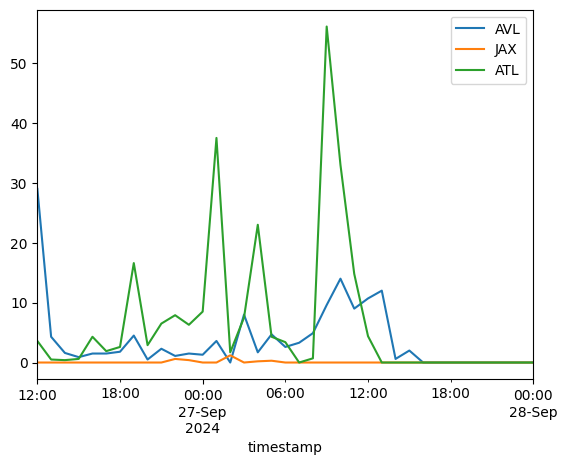

In [6]:
df.plot()